In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('../Course/Data/TimeSeriesData/Energy_Production.csv', index_col=0, parse_dates=True)

In [3]:
df.head()

,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


In [4]:
df.tail()

,IPG2211A2N
DATE,
2018-09-01,101.5656
2018-10-01,95.3203
2018-11-01,103.5750
2018-12-01,112.9498
2019-01-01,123.7687


In [5]:
df = df.dropna()

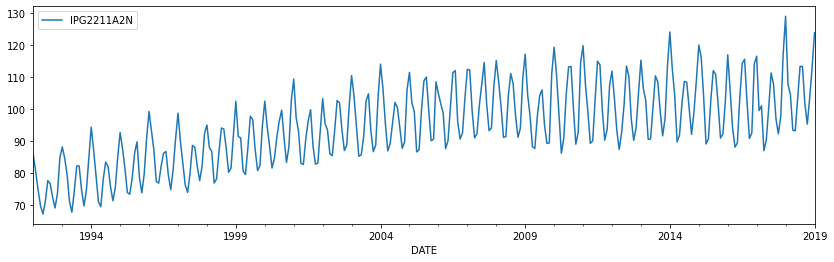

In [6]:
df.plot(figsize=(14, 4))

In [7]:
y = df['IPG2211A2N'].values.astype(float)

In [8]:
test_size = 12

In [9]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [11]:
train_set = scaler.fit_transform(train_set.reshape(-1, 1))

In [12]:
def prepare_timeseries(series, window_size):
    L = len(series)
    ts = []
    
    for i in range(L - window_size):
        window = series[i : i+window_size].cuda()
        label = series[i+window_size : i+window_size+1].cuda()
        ts.append((window, label))
        
    return ts

In [13]:
train = torch.FloatTensor(train_set).view(-1)

In [14]:
window_size = 12

In [15]:
data = prepare_timeseries(train, window_size)

In [16]:
len(data)

301

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_features=1, hidden_size=128, output_features=1):
        super().__init__()
        self.input_features = input_features
        self.hidden_size = hidden_size
        self.output_features = output_features
        
        self.lstm = nn.LSTM(self.input_features, self.hidden_size)
        
        self.fc1 = nn.Linear(self.hidden_size, self.output_features)
        
        self.hidden = (torch.zeros(1,1, self.hidden_size).cuda(), torch.zeros(1,1, self.hidden_size).cuda())
    
    def forward(self, series):
        out, self.hidden = self.lstm(series.view(len(series), 1, -1), self.hidden)
        
        out = self.fc1(out.view(len(series), -1))
        
        return out[-1]

In [18]:
model = LSTM().cuda()
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [19]:
start_time = time.time()

for i in range(epochs):
    e_start = time.time()
    
    for series, labels in data:
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(), torch.zeros(1, 1, model.hidden_size).cuda())
        
        pred = model(series)
        loss = criterion(pred, labels)
        
        loss.backward()
        optimizer.step()
    
    e_end = time.time() - e_start
    
    if (i%10)==0 or i==0 or i==(epochs-1):
        print(f"Epoch {i+1}\nLoss: {loss.item():.4f}  Duration: {(e_end/60):.2f} minutes")
    
end_time = time.time() - start_time

print(f"Training Duration {end_time/60} minutes")

Epoch 1
Loss: 0.4725  Duration: 0.05 minutes
Epoch 11
Loss: 0.2141  Duration: 0.02 minutes
Epoch 21
Loss: 0.1186  Duration: 0.02 minutes
Epoch 31
Loss: 0.0917  Duration: 0.02 minutes
Epoch 41
Loss: 0.0994  Duration: 0.02 minutes
Epoch 51
Loss: 0.1256  Duration: 0.02 minutes
Epoch 61
Loss: 0.1289  Duration: 0.02 minutes
Epoch 71
Loss: 0.1173  Duration: 0.02 minutes
Epoch 81
Loss: 0.0552  Duration: 0.02 minutes
Epoch 91
Loss: 0.0221  Duration: 0.02 minutes
Epoch 100
Loss: 0.0059  Duration: 0.02 minutes
Training Duration 2.025446895758311 minutes


In [20]:
forecast = 12

preds = train[-window_size:].tolist()

model.eval()

for i in range(forecast):
    seq = torch.FloatTensor(preds[-window_size:]).cuda()
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(), torch.zeros(1, 1, model.hidden_size).cuda())
        preds.append(model(seq).item())

In [21]:
true_preds = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [22]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]')

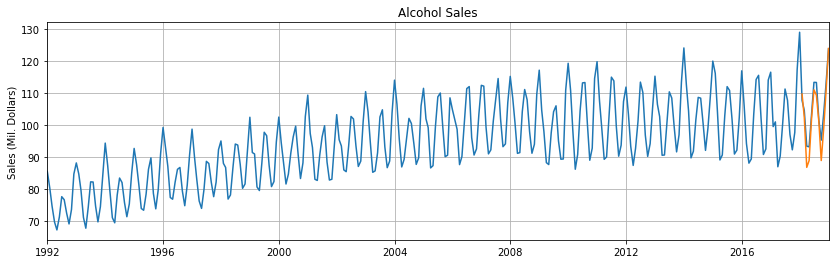

In [23]:
plt.figure(figsize=(14, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (Mil. Dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x, true_preds)
plt.show()

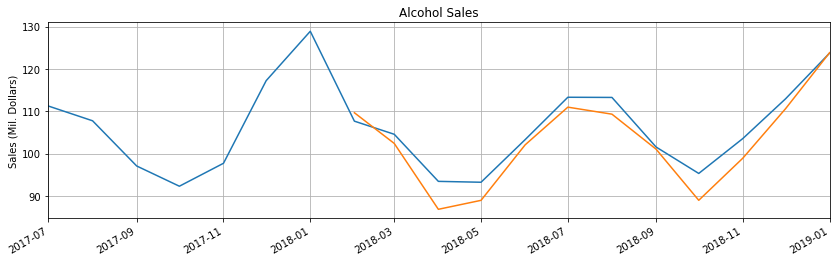

In [24]:
fig = plt.figure(figsize=(14, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (Mil. Dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-07-01':])
plt.plot(x, true_preds)
plt.show()

In [25]:
epochs = 100

model.train()

y_normalized = scaler.fit_transform(y.reshape(-1, 1))
y_normalized = torch.FloatTensor(y_normalized).view(-1)
full_data = prepare_timeseries(y_normalized, window_size)

In [26]:
start_time = time.time()

for i in range(epochs):
    e_start = time.time()
    
    for series, labels in full_data:
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(), torch.zeros(1, 1, model.hidden_size).cuda())
        
        pred = model(series)
        loss = criterion(pred, labels)
        
        loss.backward()
        optimizer.step()
    
    e_end = time.time() - e_start
    
    if (i%10)==0 or i==0 or i==(epochs-1):
        print(f"Epoch {i+1}\nLoss: {loss.item():.4f}  Duration: {(e_end/60):.2f} minutes")
    
end_time = time.time() - start_time

print(f"Training Duration {end_time/60} minutes")

Epoch 1
Loss: 0.0283  Duration: 0.02 minutes
Epoch 11
Loss: 0.0241  Duration: 0.02 minutes
Epoch 21
Loss: 0.0113  Duration: 0.02 minutes
Epoch 31
Loss: 0.0005  Duration: 0.02 minutes
Epoch 41
Loss: 0.0057  Duration: 0.02 minutes
Epoch 51
Loss: 0.0004  Duration: 0.02 minutes
Epoch 61
Loss: 0.0001  Duration: 0.02 minutes
Epoch 71
Loss: 0.0012  Duration: 0.02 minutes
Epoch 81
Loss: 0.0001  Duration: 0.02 minutes
Epoch 91
Loss: 0.0045  Duration: 0.02 minutes
Epoch 100
Loss: 0.0053  Duration: 0.02 minutes
Training Duration 2.177029629548391 minutes


In [27]:
window_size = 12
forecast = 12
L = len(y)

preds = y_normalized[-window_size:].tolist()

model.eval()

for i in range(forecast):
    seq = torch.FloatTensor(preds[-window_size:]).cuda()
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(), torch.zeros(1, 1, model.hidden_size).cuda())
        preds.append(model(seq).item())

In [28]:
true_preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

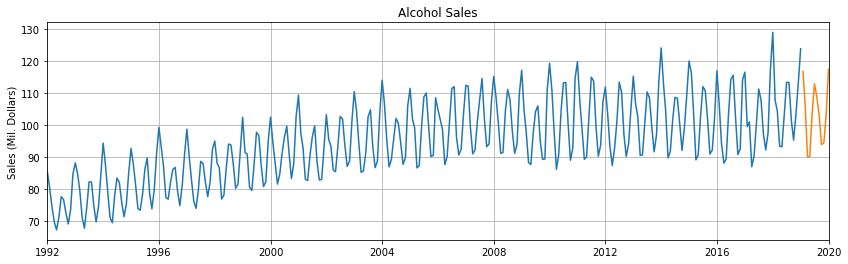

In [29]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]')

plt.figure(figsize=(14, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (Mil. Dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x, true_preds[window_size:])
plt.show()

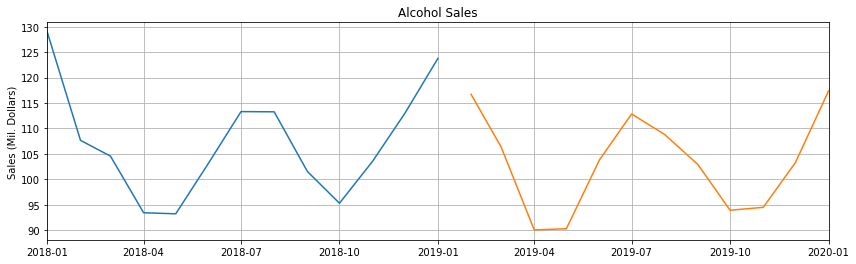

In [30]:
plt.figure(figsize=(14, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (Mil. Dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['IPG2211A2N']['2018-01-01':])
plt.plot(x, true_preds[window_size:])
plt.show()